In [56]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting

(2115, 22, 1000)
(2115, 22, 1000)
(2115, 1000)


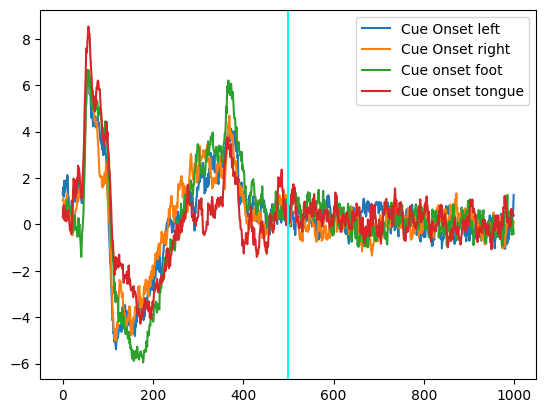

In [57]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
print(X_train_valid.shape)
ch_data = X_train_valid[:,8,:]
print(ch_data.shape)
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [58]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    # print('Shape of Y:',total_y.shape)
    return total_X,total_y



def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 1), axis=3)
    
    
    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [59]:
def hybrid(size):
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(size,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    return hybrid_cnn_lstm_model

In [60]:
X_test_prep = test_data_prep(X_test) 
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_train,y_train = train_data_prep(x_train_split,y_train_split,1,1,True)
x_valid,y_valid = train_data_prep(x_valid_split,y_valid_split,1,1,True)
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

In [61]:
# Model parameters
learning_rate = 1e-3
epochs = 150

100
Epoch 1/150
88/88 [==============================] - 4s 32ms/step - loss: 1.3955 - accuracy: 0.2618 - val_loss: 1.3769 - val_accuracy: 0.3040
Epoch 2/150
88/88 [==============================] - 3s 30ms/step - loss: 1.3886 - accuracy: 0.2726 - val_loss: 1.3757 - val_accuracy: 0.3187
Epoch 3/150
88/88 [==============================] - 3s 29ms/step - loss: 1.3814 - accuracy: 0.2795 - val_loss: 1.3725 - val_accuracy: 0.3360
Epoch 4/150
88/88 [==============================] - 3s 30ms/step - loss: 1.3776 - accuracy: 0.2954 - val_loss: 1.3752 - val_accuracy: 0.3493
Epoch 5/150
88/88 [==============================] - 3s 30ms/step - loss: 1.3717 - accuracy: 0.3139 - val_loss: 1.3704 - val_accuracy: 0.3333
Epoch 6/150
88/88 [==============================] - 3s 30ms/step - loss: 1.3655 - accuracy: 0.3226 - val_loss: 1.3575 - val_accuracy: 0.3387
Epoch 7/150
88/88 [==============================] - 3s 30ms/step - loss: 1.3585 - accuracy: 0.3239 - val_loss: 1.3604 - val_accuracy: 0.3453
Ep

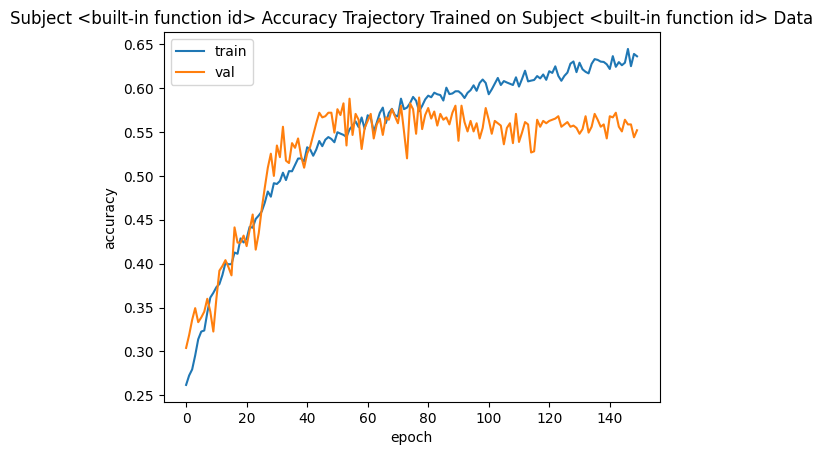

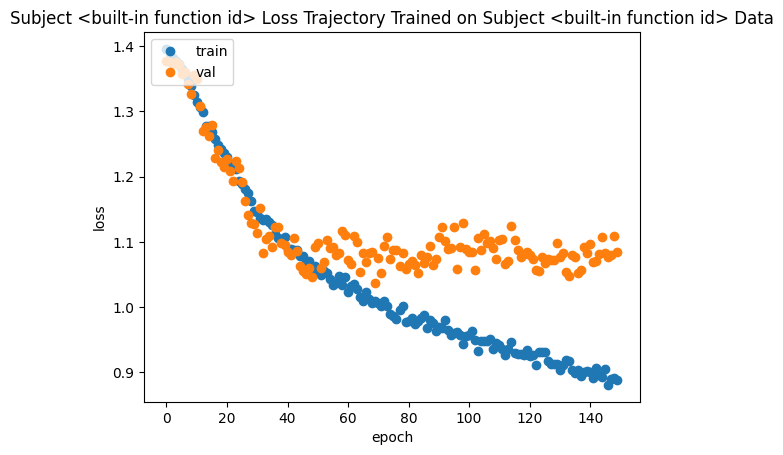

Test accuracy of the hybrid CNN-LSTM model: 0.5530474185943604
200
Epoch 1/150
88/88 [==============================] - 5s 40ms/step - loss: 1.3824 - accuracy: 0.2788 - val_loss: 1.3711 - val_accuracy: 0.3187
Epoch 2/150
88/88 [==============================] - 3s 38ms/step - loss: 1.3533 - accuracy: 0.3373 - val_loss: 1.3416 - val_accuracy: 0.3427
Epoch 3/150
88/88 [==============================] - 3s 39ms/step - loss: 1.3246 - accuracy: 0.3714 - val_loss: 1.3469 - val_accuracy: 0.3640
Epoch 4/150
88/88 [==============================] - 3s 38ms/step - loss: 1.3058 - accuracy: 0.3859 - val_loss: 1.3093 - val_accuracy: 0.3947
Epoch 5/150
88/88 [==============================] - 3s 39ms/step - loss: 1.2797 - accuracy: 0.4041 - val_loss: 1.3033 - val_accuracy: 0.3707
Epoch 6/150
88/88 [==============================] - 3s 40ms/step - loss: 1.2648 - accuracy: 0.4182 - val_loss: 1.2998 - val_accuracy: 0.3653
Epoch 7/150
88/88 [==============================] - 4s 40ms/step - loss: 1.2529 

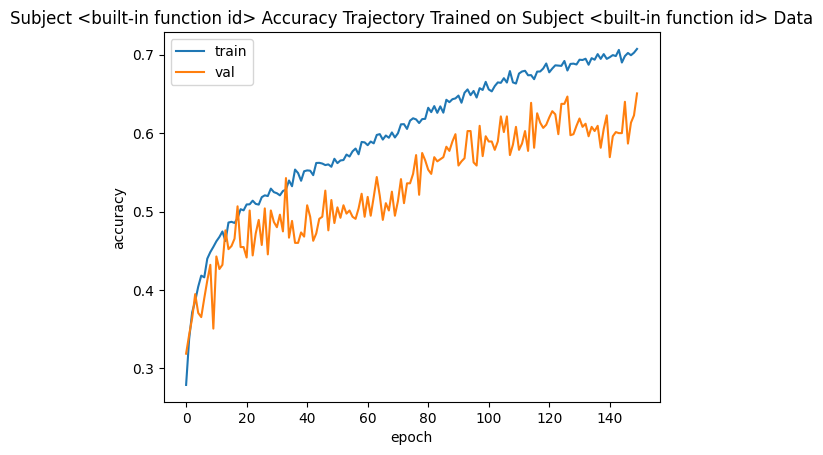

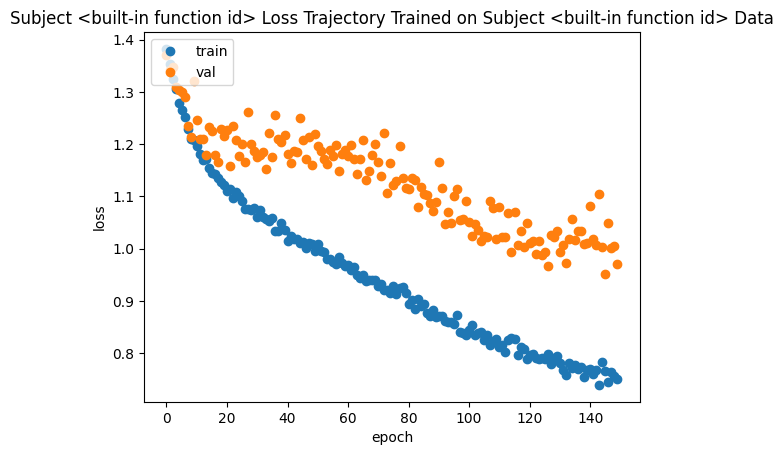

Test accuracy of the hybrid CNN-LSTM model: 0.6117381453514099
300
Epoch 1/150
88/88 [==============================] - 6s 52ms/step - loss: 1.3830 - accuracy: 0.2851 - val_loss: 1.3645 - val_accuracy: 0.2880
Epoch 2/150
88/88 [==============================] - 4s 48ms/step - loss: 1.3469 - accuracy: 0.3246 - val_loss: 1.3079 - val_accuracy: 0.3293
Epoch 3/150
88/88 [==============================] - 4s 50ms/step - loss: 1.3111 - accuracy: 0.3696 - val_loss: 1.2781 - val_accuracy: 0.3933
Epoch 4/150
88/88 [==============================] - 4s 47ms/step - loss: 1.2779 - accuracy: 0.4097 - val_loss: 1.3675 - val_accuracy: 0.3280
Epoch 5/150
88/88 [==============================] - 4s 49ms/step - loss: 1.2438 - accuracy: 0.4279 - val_loss: 1.2580 - val_accuracy: 0.3867
Epoch 6/150
88/88 [==============================] - 4s 49ms/step - loss: 1.2291 - accuracy: 0.4422 - val_loss: 1.3224 - val_accuracy: 0.3693
Epoch 7/150
88/88 [==============================] - 4s 48ms/step - loss: 1.2076 

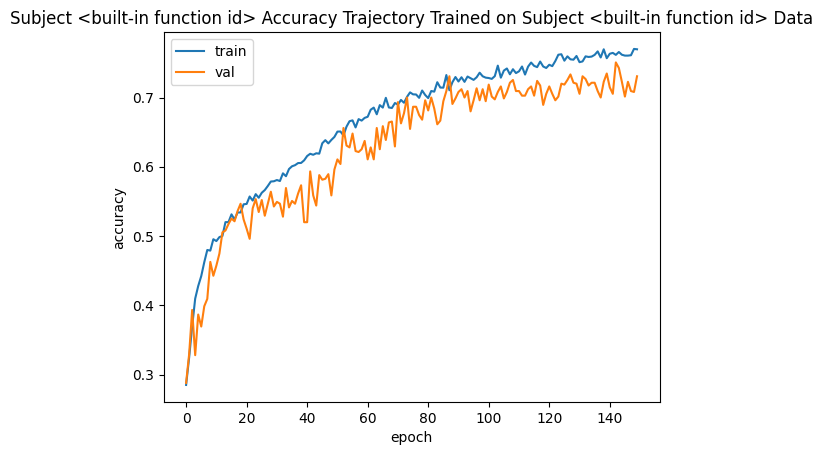

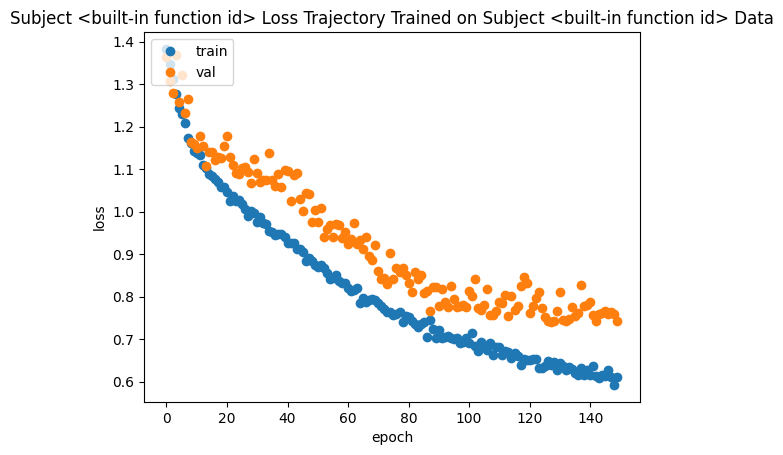

Test accuracy of the hybrid CNN-LSTM model: 0.7133182883262634
400
Epoch 1/150
88/88 [==============================] - 7s 60ms/step - loss: 1.3757 - accuracy: 0.2828 - val_loss: 1.3475 - val_accuracy: 0.3027
Epoch 2/150
88/88 [==============================] - 5s 60ms/step - loss: 1.3318 - accuracy: 0.3448 - val_loss: 1.2926 - val_accuracy: 0.3187
Epoch 3/150
88/88 [==============================] - 5s 59ms/step - loss: 1.2903 - accuracy: 0.3937 - val_loss: 1.2862 - val_accuracy: 0.3627
Epoch 4/150
88/88 [==============================] - 5s 57ms/step - loss: 1.2585 - accuracy: 0.4145 - val_loss: 1.2741 - val_accuracy: 0.3947
Epoch 5/150
88/88 [==============================] - 5s 57ms/step - loss: 1.2160 - accuracy: 0.4425 - val_loss: 1.2054 - val_accuracy: 0.3960
Epoch 6/150
88/88 [==============================] - 5s 57ms/step - loss: 1.1898 - accuracy: 0.4533 - val_loss: 1.2007 - val_accuracy: 0.4400
Epoch 7/150
88/88 [==============================] - 5s 59ms/step - loss: 1.1668 

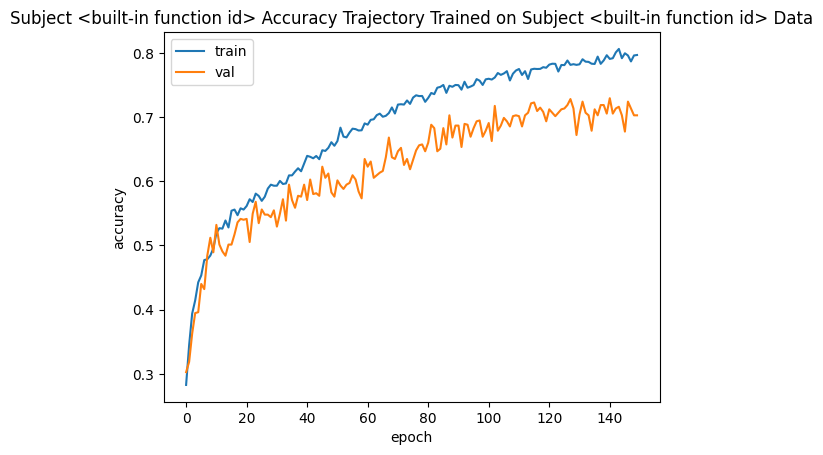

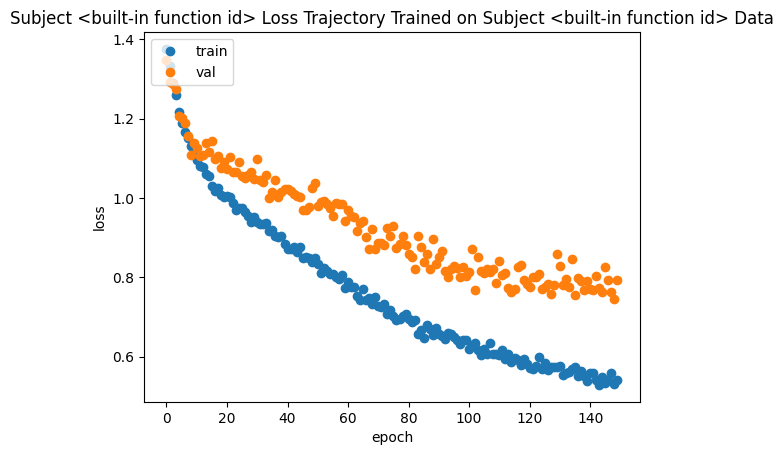

Test accuracy of the hybrid CNN-LSTM model: 0.6794582605361938
500
Epoch 1/150
88/88 [==============================] - 7s 68ms/step - loss: 1.3918 - accuracy: 0.2651 - val_loss: 1.3493 - val_accuracy: 0.3440
Epoch 2/150
88/88 [==============================] - 6s 66ms/step - loss: 1.3531 - accuracy: 0.3308 - val_loss: 1.3397 - val_accuracy: 0.3360
Epoch 3/150
88/88 [==============================] - 6s 65ms/step - loss: 1.3121 - accuracy: 0.3576 - val_loss: 1.3286 - val_accuracy: 0.3133
Epoch 4/150
88/88 [==============================] - 6s 65ms/step - loss: 1.2834 - accuracy: 0.3837 - val_loss: 1.2920 - val_accuracy: 0.3493
Epoch 5/150
88/88 [==============================] - 6s 71ms/step - loss: 1.2563 - accuracy: 0.4157 - val_loss: 1.2422 - val_accuracy: 0.4520
Epoch 6/150
88/88 [==============================] - 6s 69ms/step - loss: 1.2306 - accuracy: 0.4411 - val_loss: 1.2241 - val_accuracy: 0.4107
Epoch 7/150
88/88 [==============================] - 6s 68ms/step - loss: 1.2037 

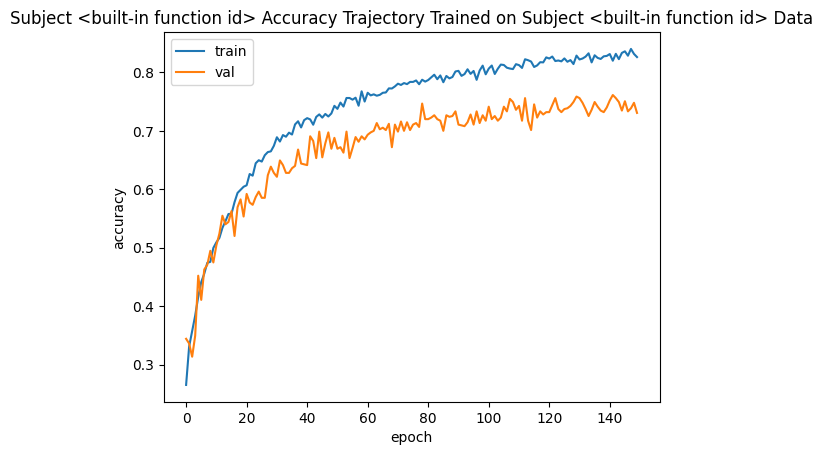

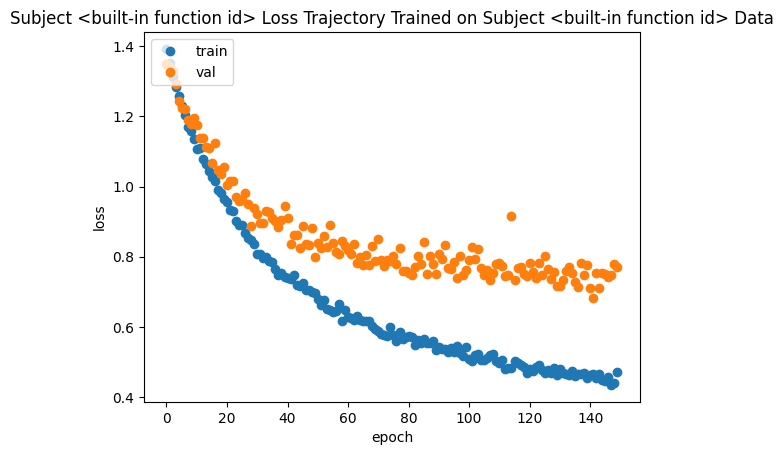

Test accuracy of the hybrid CNN-LSTM model: 0.6930022835731506
600
Epoch 1/150
88/88 [==============================] - 8s 77ms/step - loss: 1.3862 - accuracy: 0.2701 - val_loss: 1.3609 - val_accuracy: 0.3400
Epoch 2/150
88/88 [==============================] - 7s 75ms/step - loss: 1.3471 - accuracy: 0.3491 - val_loss: 1.3253 - val_accuracy: 0.3187
Epoch 3/150
88/88 [==============================] - 7s 75ms/step - loss: 1.2826 - accuracy: 0.4206 - val_loss: 1.2508 - val_accuracy: 0.4213
Epoch 4/150
88/88 [==============================] - 7s 76ms/step - loss: 1.2241 - accuracy: 0.4611 - val_loss: 1.2360 - val_accuracy: 0.4387
Epoch 5/150
88/88 [==============================] - 7s 76ms/step - loss: 1.1954 - accuracy: 0.4715 - val_loss: 1.2596 - val_accuracy: 0.4360
Epoch 6/150
88/88 [==============================] - 6s 73ms/step - loss: 1.1683 - accuracy: 0.4920 - val_loss: 1.2110 - val_accuracy: 0.4520
Epoch 7/150
88/88 [==============================] - 6s 74ms/step - loss: 1.1416 

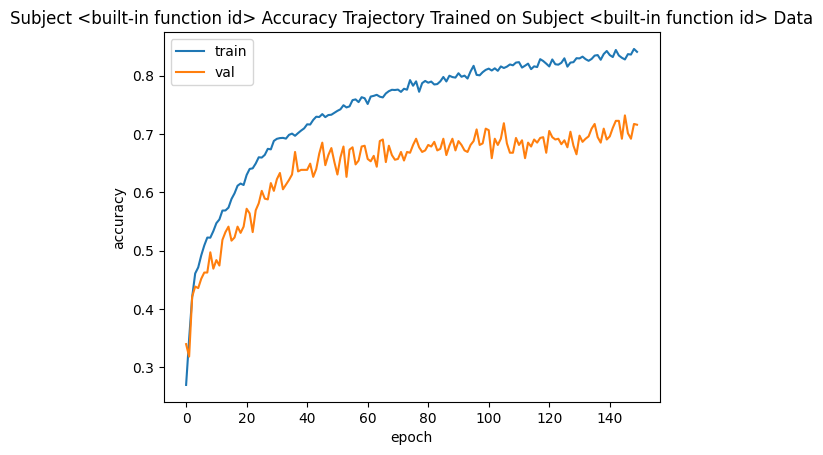

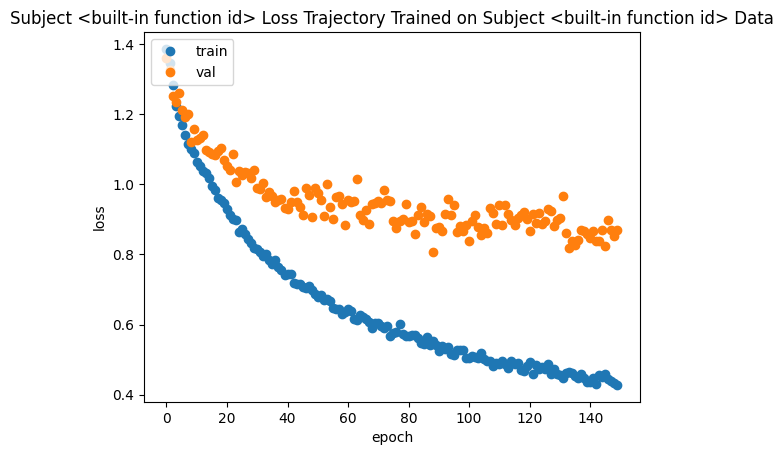

Test accuracy of the hybrid CNN-LSTM model: 0.6681715846061707
700
Epoch 1/150
88/88 [==============================] - 9s 84ms/step - loss: 1.3776 - accuracy: 0.2953 - val_loss: 1.3305 - val_accuracy: 0.3627
Epoch 2/150
88/88 [==============================] - 7s 80ms/step - loss: 1.3088 - accuracy: 0.3843 - val_loss: 1.2885 - val_accuracy: 0.4027
Epoch 3/150
88/88 [==============================] - 7s 80ms/step - loss: 1.2514 - accuracy: 0.4282 - val_loss: 1.2723 - val_accuracy: 0.4173
Epoch 4/150
88/88 [==============================] - 7s 80ms/step - loss: 1.2146 - accuracy: 0.4547 - val_loss: 1.2394 - val_accuracy: 0.4000
Epoch 5/150
88/88 [==============================] - 7s 81ms/step - loss: 1.1881 - accuracy: 0.4688 - val_loss: 1.1860 - val_accuracy: 0.4400
Epoch 6/150
88/88 [==============================] - 7s 80ms/step - loss: 1.1650 - accuracy: 0.4874 - val_loss: 1.1952 - val_accuracy: 0.4600
Epoch 7/150
88/88 [==============================] - 7s 77ms/step - loss: 1.1558 

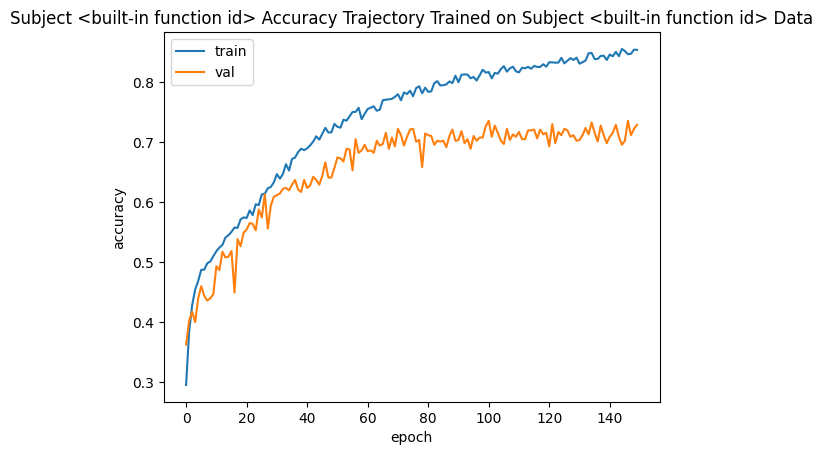

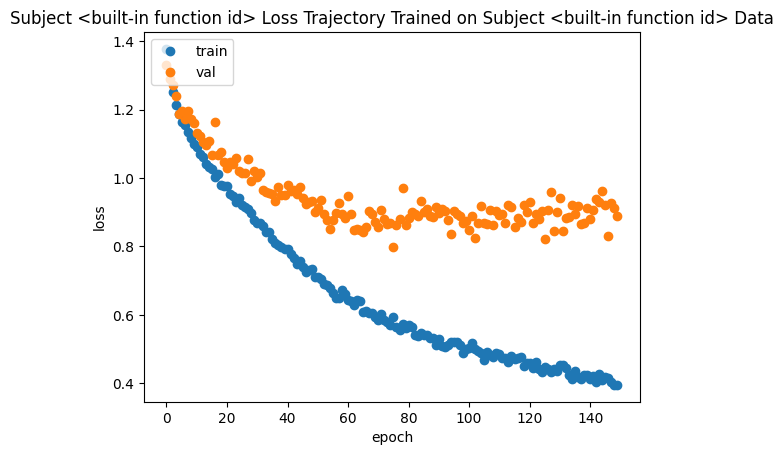

Test accuracy of the hybrid CNN-LSTM model: 0.6794582605361938
800
Epoch 1/150
88/88 [==============================] - 10s 96ms/step - loss: 1.3811 - accuracy: 0.2887 - val_loss: 1.3663 - val_accuracy: 0.2880
Epoch 2/150
88/88 [==============================] - 8s 91ms/step - loss: 1.3416 - accuracy: 0.3539 - val_loss: 1.3090 - val_accuracy: 0.3853
Epoch 3/150
88/88 [==============================] - 8s 91ms/step - loss: 1.2775 - accuracy: 0.4125 - val_loss: 1.2750 - val_accuracy: 0.4200
Epoch 4/150
88/88 [==============================] - 8s 90ms/step - loss: 1.2290 - accuracy: 0.4413 - val_loss: 1.1776 - val_accuracy: 0.4920
Epoch 5/150
88/88 [==============================] - 8s 90ms/step - loss: 1.1979 - accuracy: 0.4518 - val_loss: 1.1882 - val_accuracy: 0.4867
Epoch 6/150
88/88 [==============================] - 8s 89ms/step - loss: 1.1680 - accuracy: 0.4652 - val_loss: 1.1612 - val_accuracy: 0.4787
Epoch 7/150
88/88 [==============================] - 8s 89ms/step - loss: 1.1521

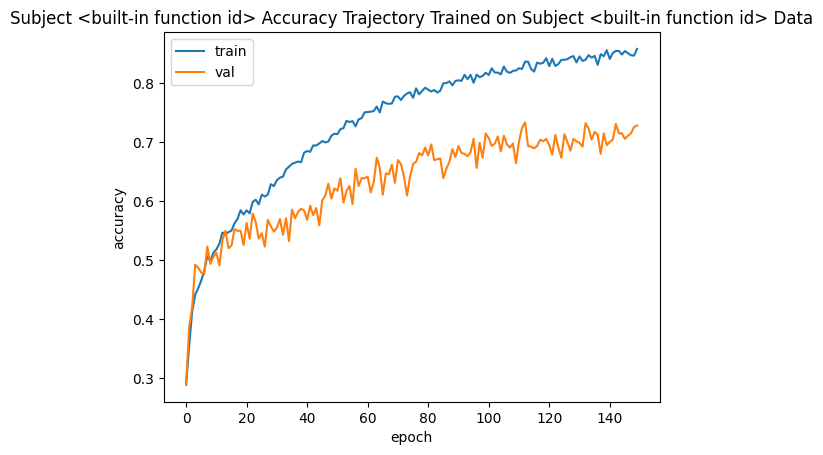

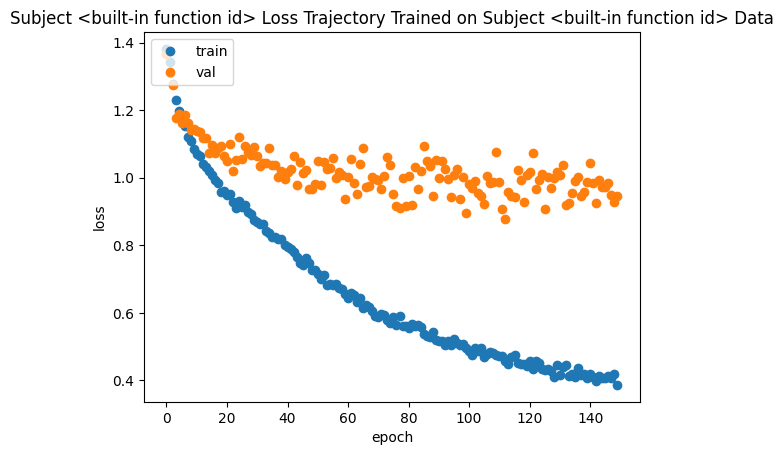

Test accuracy of the hybrid CNN-LSTM model: 0.6568848490715027
900
Epoch 1/150
88/88 [==============================] - 10s 95ms/step - loss: 1.3932 - accuracy: 0.2533 - val_loss: 1.3761 - val_accuracy: 0.3520
Epoch 2/150
88/88 [==============================] - 8s 92ms/step - loss: 1.3781 - accuracy: 0.2833 - val_loss: 1.3450 - val_accuracy: 0.3493
Epoch 3/150
88/88 [==============================] - 8s 92ms/step - loss: 1.3486 - accuracy: 0.3399 - val_loss: 1.3054 - val_accuracy: 0.3427
Epoch 4/150
88/88 [==============================] - 9s 98ms/step - loss: 1.2996 - accuracy: 0.3812 - val_loss: 1.3351 - val_accuracy: 0.3107
Epoch 5/150
88/88 [==============================] - 9s 100ms/step - loss: 1.2717 - accuracy: 0.3966 - val_loss: 1.2823 - val_accuracy: 0.3933
Epoch 6/150
88/88 [==============================] - 9s 97ms/step - loss: 1.2375 - accuracy: 0.4382 - val_loss: 1.2455 - val_accuracy: 0.4040
Epoch 7/150
88/88 [==============================] - 8s 96ms/step - loss: 1.219

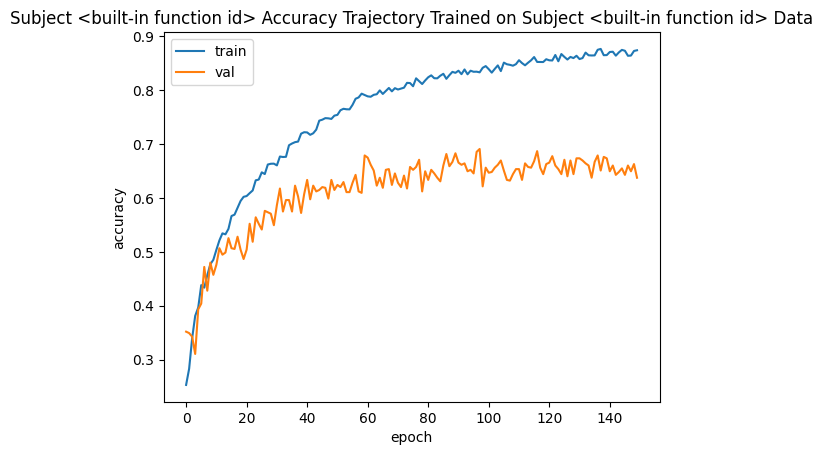

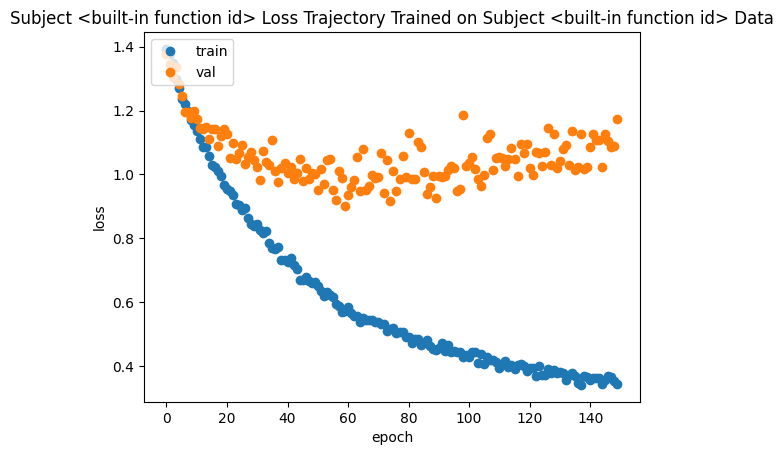

Test accuracy of the hybrid CNN-LSTM model: 0.6139954924583435
1000
Epoch 1/150
88/88 [==============================] - 10s 102ms/step - loss: 1.3905 - accuracy: 0.2729 - val_loss: 1.3732 - val_accuracy: 0.3013
Epoch 2/150
88/88 [==============================] - 9s 100ms/step - loss: 1.3682 - accuracy: 0.3049 - val_loss: 1.3369 - val_accuracy: 0.3267
Epoch 3/150
88/88 [==============================] - 9s 99ms/step - loss: 1.3351 - accuracy: 0.3555 - val_loss: 1.2976 - val_accuracy: 0.3667
Epoch 4/150
88/88 [==============================] - 9s 99ms/step - loss: 1.2767 - accuracy: 0.3996 - val_loss: 1.2227 - val_accuracy: 0.4227
Epoch 5/150
88/88 [==============================] - 9s 100ms/step - loss: 1.2313 - accuracy: 0.4420 - val_loss: 1.2109 - val_accuracy: 0.4147
Epoch 6/150
88/88 [==============================] - 9s 100ms/step - loss: 1.2090 - accuracy: 0.4565 - val_loss: 1.1969 - val_accuracy: 0.4267
Epoch 7/150
88/88 [==============================] - 9s 101ms/step - loss: 

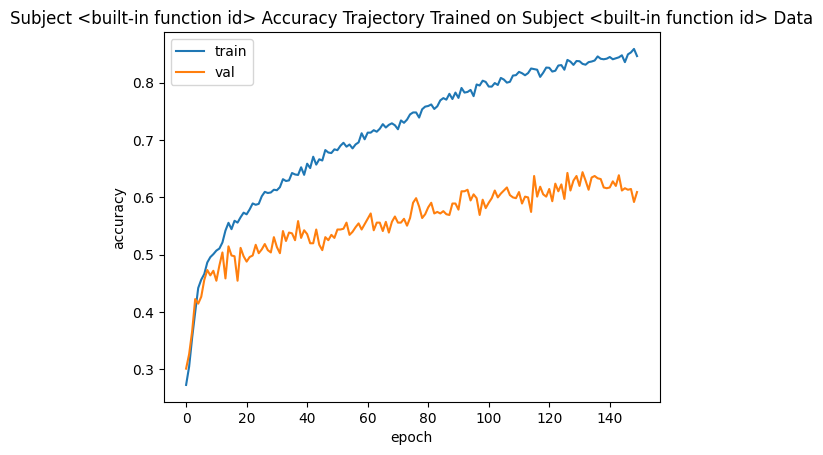

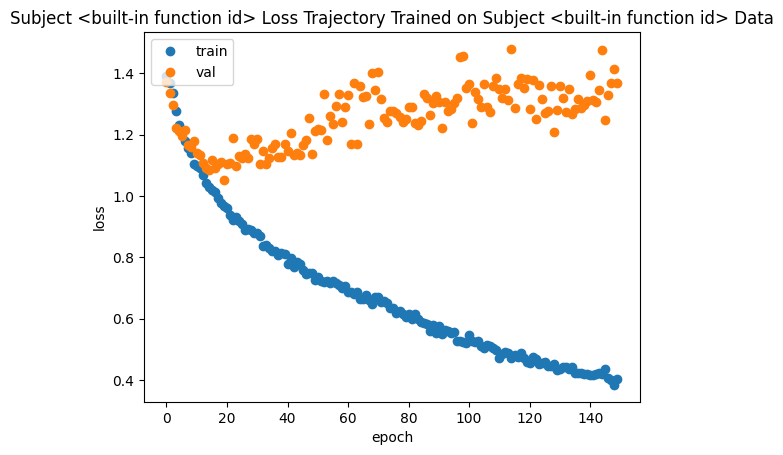

Test accuracy of the hybrid CNN-LSTM model: 0.5914221405982971


In [62]:
accuracy = []

for i in range(100, 1001, 100):
    print(i)
    x_train_trim = x_train[:, :i, :, :]
    x_valid_trim = x_valid[:, :i, :, :]
    x_test_trim = x_test[:, :i, :, :]

    hybrid_cnn_lstm_model = hybrid(i)
    # ADAM
    # Compiling the model
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_trim,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_trim, y_valid), verbose=True)

    # Plotting accuracy trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['accuracy'])
    plt.plot( hybrid_cnn_lstm_model_results.history['val_accuracy'])
    plt.title('Subject ' + str(id) + ' Accuracy Trajectory Trained on Subject ' + str(id) + ' Data')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plotting loss trajectory
    plt.plot( hybrid_cnn_lstm_model_results.history['loss'],'o')
    plt.plot( hybrid_cnn_lstm_model_results.history['val_loss'],'o')
    plt.title('Subject '  + str(id) + ' Loss Trajectory Trained on Subject '  + str(id) + ' Data')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_trim, y_test, verbose=0)
    print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
    accuracy.append(hybrid_cnn_lstm_score[1])
    

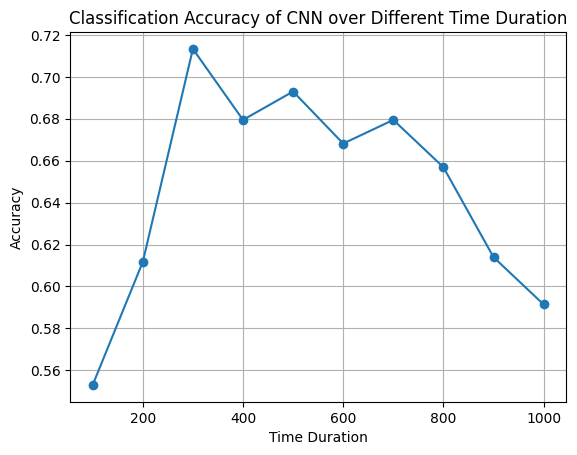

In [63]:
time_duration = list(range(100, 1001, 100))

# Plotting
plt.plot(time_duration, accuracy, marker='o')
plt.title('Classification Accuracy of CNN over Different Time Duration')
plt.xlabel('Time Duration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
